### 1.加载数据

In [58]:
import keras
import numpy as np
import matplotlib.pyplot as plt
from keras.layers import Dense,Dropout
from keras.models import Model,Sequential
from keras.datasets import mnist
from keras.utils import to_categorical
from keras.optimizers import SGD 

In [59]:
def load_data():
    (x_train, y_train), (x_test, y_test) = mnist.load_data()
    x_train = (x_train.astype(np.float32) - 127.5)/127.5
    
    # convert shape of x_train from (60000, 28, 28) to (60000, 784) 
    # 784 columns per row
    x_train = x_train.reshape(-1, 784)
    x_train=x_train[:50000]
    y_train=y_train[:50000]
    x_test=x_test.reshape(-1,784)
    y_test=to_categorical(y_test)
    y_train=to_categorical(y_train)
    return (x_train, y_train, x_test, y_test)

(X_train, y_train,X_test, y_test)=load_data()

print('X_train shape: {0} '.format(X_train.shape))
print('y_train shape: {0}'.format(y_train.shape))
print('X_test shape: {0}'.format(X_test.shape))
print('y_test shape: {0}'.format(y_test.shape))

X_train shape: (50000, 784) 
y_train shape: (50000, 10)
X_test shape: (10000, 784)
y_test shape: (10000, 10)


### 2.自定义的优化器

In [60]:
from keras.optimizers import Optimizer
import six
import copy
from six.moves import zip

from keras import backend as K
from keras.utils.generic_utils import serialize_keras_object
from keras.utils.generic_utils import deserialize_keras_object
from keras.legacy import interfaces
import numpy as np
class mySGD(Optimizer):
    """Stochastic gradient descent optimizer.
    Includes support for momentum,
    learning rate decay, and Nesterov momentum.
    # Arguments
        lr: float >= 0. Learning rate.
        momentum: float >= 0. Parameter that accelerates SGD
            in the relevant direction and dampens oscillations.
        decay: float >= 0. Learning rate decay over each update.
        nesterov: boolean. Whether to apply Nesterov momentum.
    """

    def __init__(self, lr=0.01, momentum=0., decay=0.,
                 nesterov=False, **kwargs):
        super(mySGD, self).__init__(**kwargs)
        with K.name_scope(self.__class__.__name__):
            self.iterations = K.variable(0, dtype='int64', name='iterations')
            self.lr = K.variable(lr, name='lr')
            self.momentum = K.variable(momentum, name='momentum')
            self.decay = K.variable(decay, name='decay')
        self.initial_decay = decay
        self.nesterov = nesterov

    @interfaces.legacy_get_updates_support
    def get_updates(self, loss, params):
        grads = self.get_gradients(loss, params)
        self.updates = [K.update_add(self.iterations, 1)]

        lr = self.lr
        if self.initial_decay > 0:
            lr = lr * (1. / (1. + self.decay * K.cast(self.iterations,
                                                      K.dtype(self.decay))))
#         print(grads)
        # momentum
        shapes = [K.int_shape(p) for p in params]
        moments = [K.zeros(shape) for shape in shapes]
        self.weights = [self.iterations] + moments
        for p, g, m in zip(params, grads, moments):
#             print(params[0].shape)
#             print(params[0].read_value())
#             with sess.as_default():
#                 print(params[0].eval())
            
#             print(tf.norm(params[0],ord='euclidean'))
#             v = self.momentum * m - lr * g  # velocity
            v = self.momentum * m - tf.norm(p,ord='euclidean')*lr /tf.norm(g,ord='euclidean')* g  # velocity
            self.updates.append(K.update(m, v))
            
            if self.nesterov:
                new_p = p + self.momentum * v - lr * g
            else:
                new_p = p + v

            # Apply constraints.
            if getattr(p, 'constraint', None) is not None:
                new_p = p.constraint(new_p)

            self.updates.append(K.update(p, new_p))
        return self.updates

    def get_config(self):
        config = {'lr': float(K.get_value(self.lr)),
                  'momentum': float(K.get_value(self.momentum)),
                  'decay': float(K.get_value(self.decay)),
                  'nesterov': self.nesterov}
        base_config = super(SGD, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

### 3.test custom optimizer can work

In [61]:
model=Sequential()
model.add(Dense(units=20,input_shape=(100,)))
model.add(Dense(units=5))
model.summary()
model.compile(optimizer=mySGD(),loss='categorical_crossentropy',metrics=['acc'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_26 (Dense)             (None, 20)                2020      
_________________________________________________________________
dense_27 (Dense)             (None, 5)                 105       
Total params: 2,125
Trainable params: 2,125
Non-trainable params: 0
_________________________________________________________________


In [62]:
num_train=10
training_data=np.random.normal(0,1,[num_train,100])
labels=np.random.randint(low=0,high=5,size=[num_train])
labels=to_categorical(labels)
print('training data shape : {0}'.format(training_data.shape))
print('labels.shape :{0}'.format(labels.shape))

training data shape : (10, 100)
labels.shape :(10, 5)


In [63]:
batch_size=2
epochs=1
model.fit(training_data,labels,epochs=epochs,batch_size=batch_size)

[<tf.Tensor 'training_11/mySGD/gradients/dense_26/MatMul_grad/MatMul_1:0' shape=(100, 20) dtype=float32>, <tf.Tensor 'training_11/mySGD/gradients/dense_26/BiasAdd_grad/BiasAddGrad:0' shape=(20,) dtype=float32>, <tf.Tensor 'training_11/mySGD/gradients/dense_27/MatMul_grad/MatMul_1:0' shape=(20, 5) dtype=float32>, <tf.Tensor 'training_11/mySGD/gradients/dense_27/BiasAdd_grad/BiasAddGrad:0' shape=(5,) dtype=float32>]
Epoch 1/1
10/10 [==============================] - 0s 27ms/step - loss: 5.0481 - acc: 0.2000


### 4.real model

In [68]:
model=Sequential()
model.add(Dense(units=400,input_shape=(784,),activation='sigmoid'))
for i in range(350,0,-50):
    model.add(Dense(units=i,activation='sigmoid'))
model.add(Dense(units=10,activation='softmax'))
model.summary()

learning_rate=0.003
model.compile(loss='categorical_crossentropy',optimizer=mySGD(lr=learning_rate),metrics=['acc'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_46 (Dense)             (None, 400)               314000    
_________________________________________________________________
dense_47 (Dense)             (None, 350)               140350    
_________________________________________________________________
dense_48 (Dense)             (None, 300)               105300    
_________________________________________________________________
dense_49 (Dense)             (None, 250)               75250     
_________________________________________________________________
dense_50 (Dense)             (None, 200)               50200     
_________________________________________________________________
dense_51 (Dense)             (None, 150)               30150     
_________________________________________________________________
dense_52 (Dense)             (None, 100)               15100     
__________

### 5.新优化器效果,注意到从之前无法训练变为能够下降了,但准确率非常低

In [69]:
batch_size=128
epochs=20
history=model.fit(X_train,y_train,
          batch_size=batch_size,
         epochs=epochs,
         validation_data=[X_test,y_test])

[<tf.Tensor 'training_14/mySGD/gradients/dense_46/MatMul_grad/MatMul_1:0' shape=(784, 400) dtype=float32>, <tf.Tensor 'training_14/mySGD/gradients/dense_46/BiasAdd_grad/BiasAddGrad:0' shape=(400,) dtype=float32>, <tf.Tensor 'training_14/mySGD/gradients/dense_47/MatMul_grad/MatMul_1:0' shape=(400, 350) dtype=float32>, <tf.Tensor 'training_14/mySGD/gradients/dense_47/BiasAdd_grad/BiasAddGrad:0' shape=(350,) dtype=float32>, <tf.Tensor 'training_14/mySGD/gradients/dense_48/MatMul_grad/MatMul_1:0' shape=(350, 300) dtype=float32>, <tf.Tensor 'training_14/mySGD/gradients/dense_48/BiasAdd_grad/BiasAddGrad:0' shape=(300,) dtype=float32>, <tf.Tensor 'training_14/mySGD/gradients/dense_49/MatMul_grad/MatMul_1:0' shape=(300, 250) dtype=float32>, <tf.Tensor 'training_14/mySGD/gradients/dense_49/BiasAdd_grad/BiasAddGrad:0' shape=(250,) dtype=float32>, <tf.Tensor 'training_14/mySGD/gradients/dense_50/MatMul_grad/MatMul_1:0' shape=(250, 200) dtype=float32>, <tf.Tensor 'training_14/mySGD/gradients/dense

In [70]:
def plot_acc_loss(history):
    plt.plot(history.history['acc'],color='blue',label='train_accracy')
    plt.plot(history.history['val_acc'],color='red',label='test_accracy')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.legend()
    plt.show()
    plt.figure()
    plt.plot(history.history['loss'],color='blue',label='train_loss')
    plt.plot(history.history['val_loss'],color='red',label='test_loss')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.legend()
    plt.show()

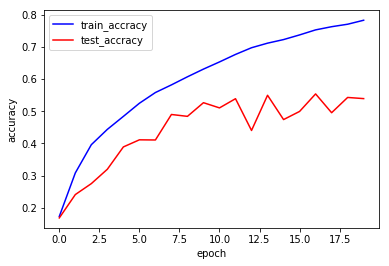

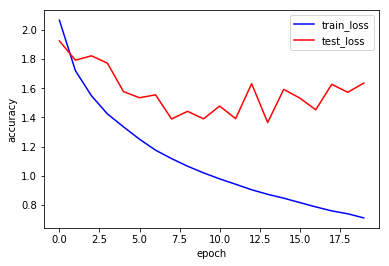

In [71]:
plot_acc_loss(history)

### 6.新方法已经达到了从不能到能的期望,但准确率太低,为说明其具有正常的收敛性能,接下来主要目的是得到一个较好训练结果